In [10]:
from ssapp.data.AntennaDatasetLoaders import MLADataset1
from torch.utils.data.dataloader import DataLoader  
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.Utils import FigureSaver
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver(subfolder='MLA_PCA_Components',default_format='png')

dataset = load_serialized_dataset('MLADataset1_Train')

params, fields = next(iter(DataLoader(dataset, batch_size=len(dataset))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


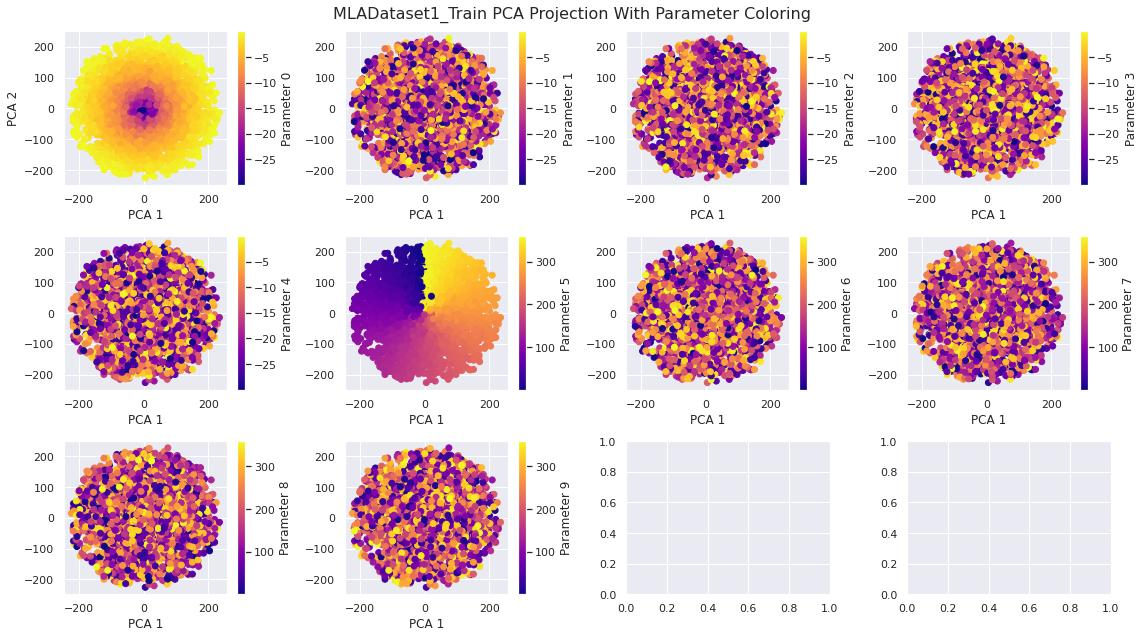

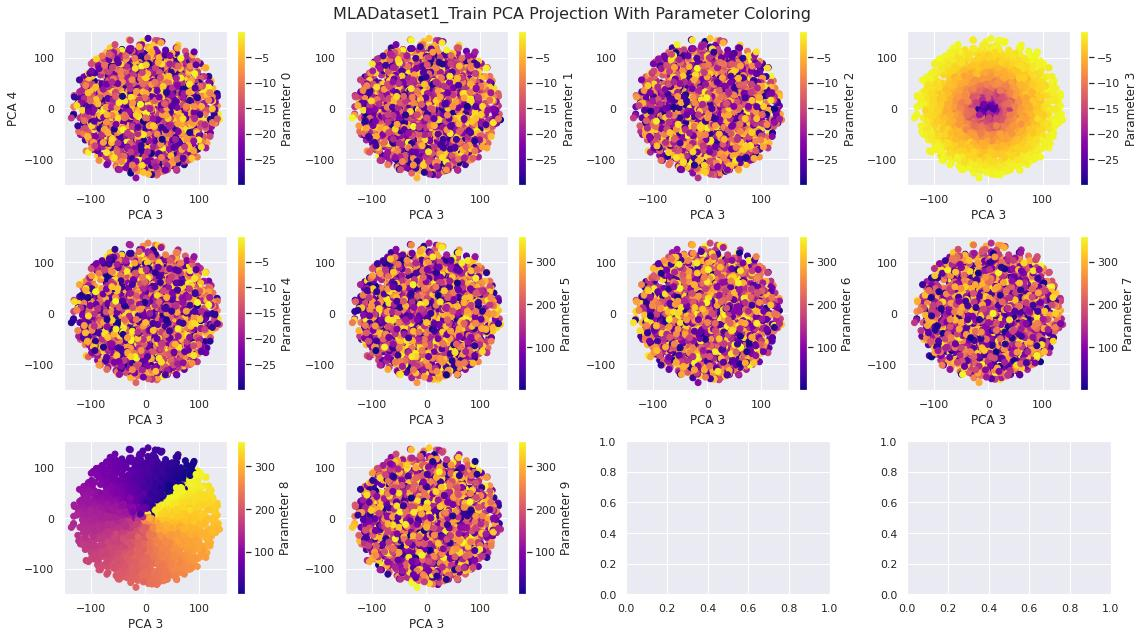

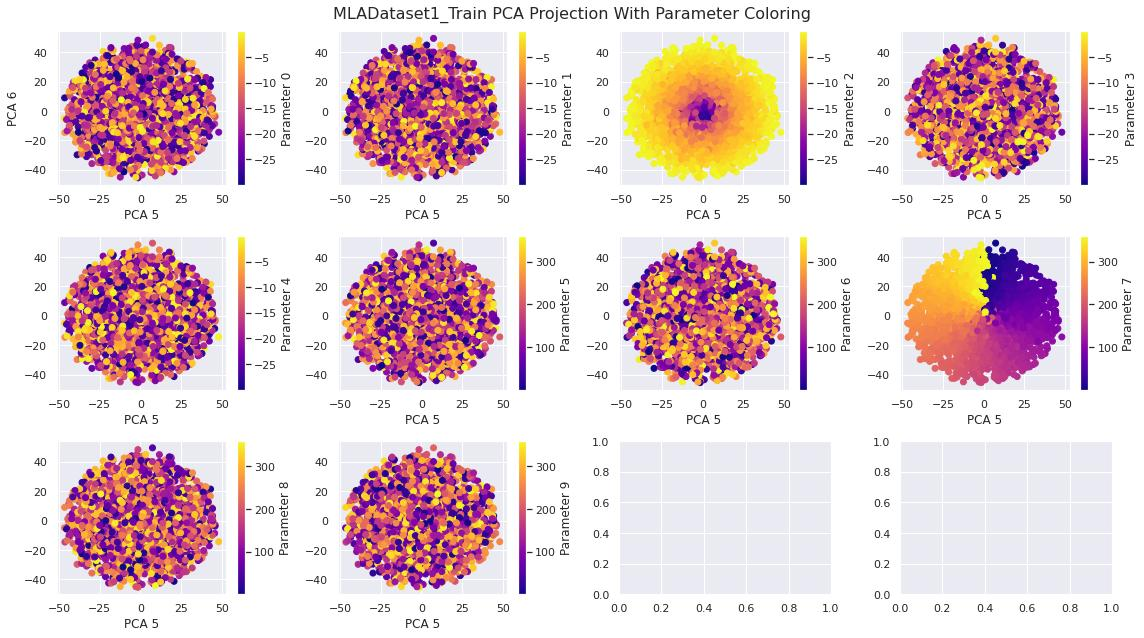

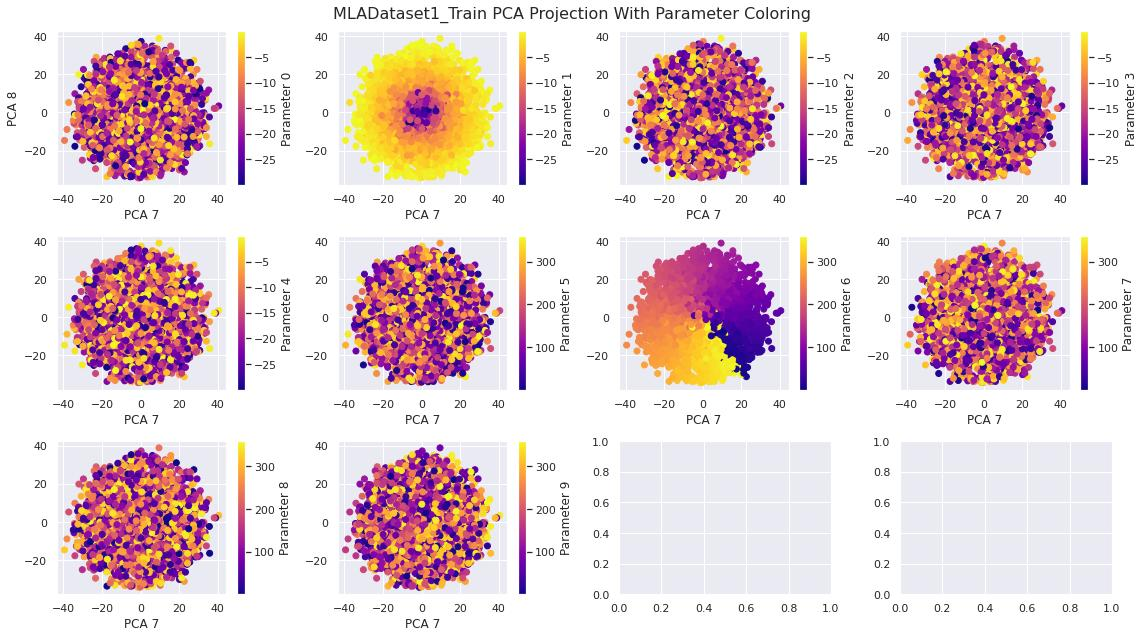

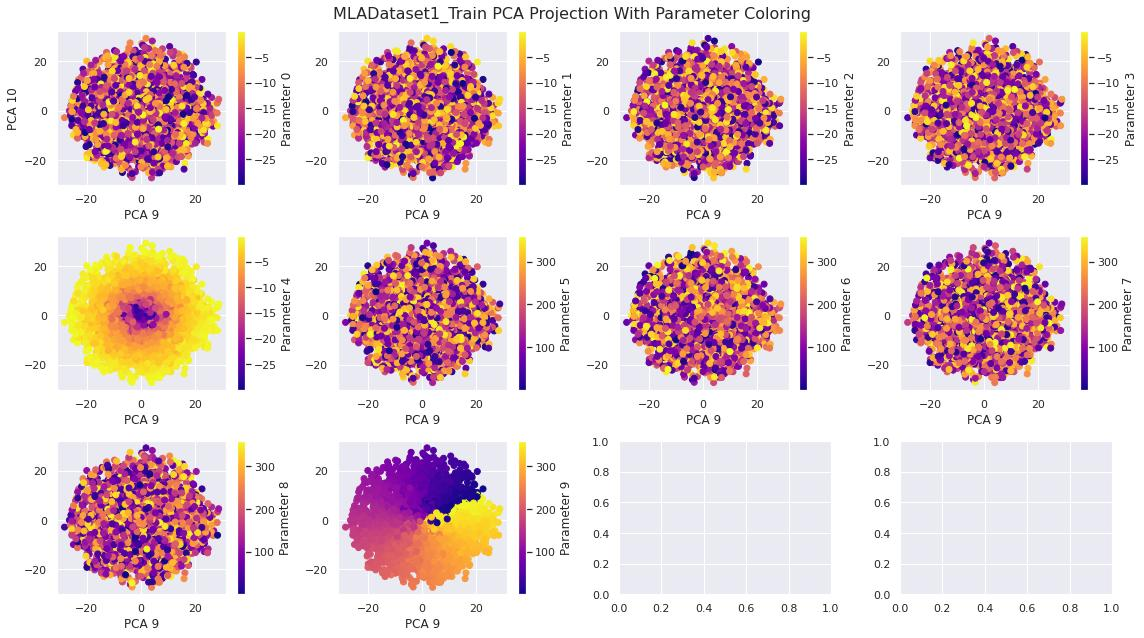

In [3]:
from ssapp.visualization.PCA_Visualisation import plotParameterColoredLatentSpace
dataset_train = load_serialized_dataset('MLADataset1_Train')

for pcx,pcy in [(x,x+1) for x in range(1,11,2)]:  
    plotParameterColoredLatentSpace(dataset,figsize=(16,9), layout_shape = (3,4),pca_components=(pcx,pcy))
    figSaver.save('MLA_PCA_'+str(pcx)+'_'+str(pcy)+'')



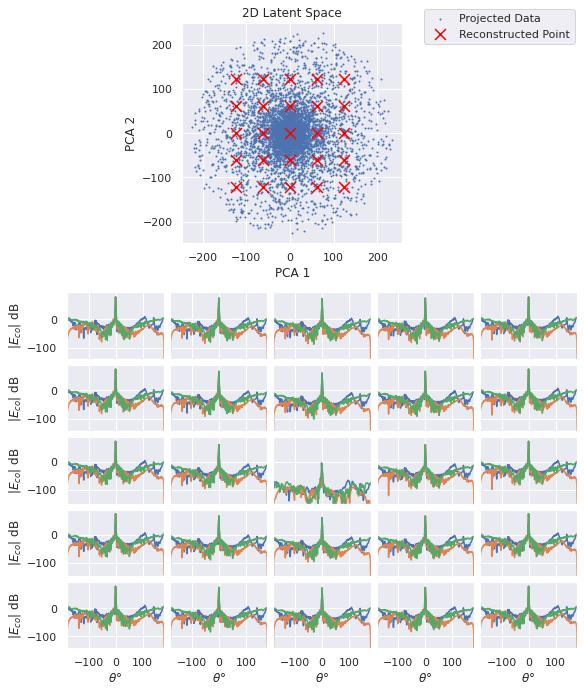

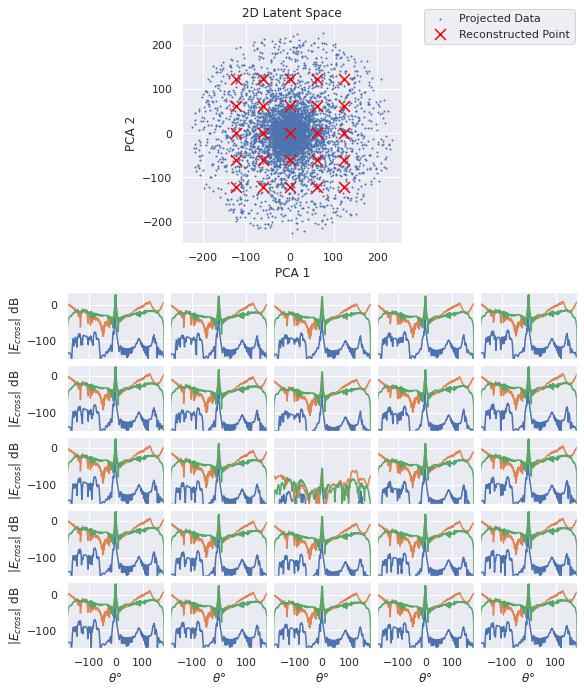

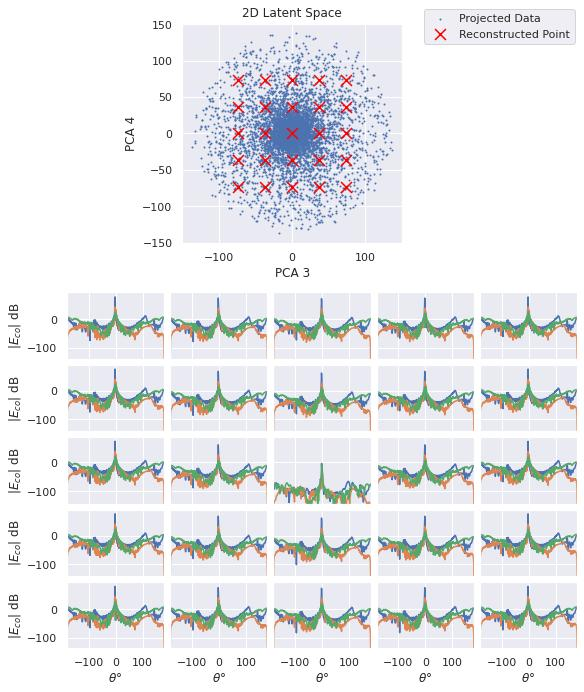

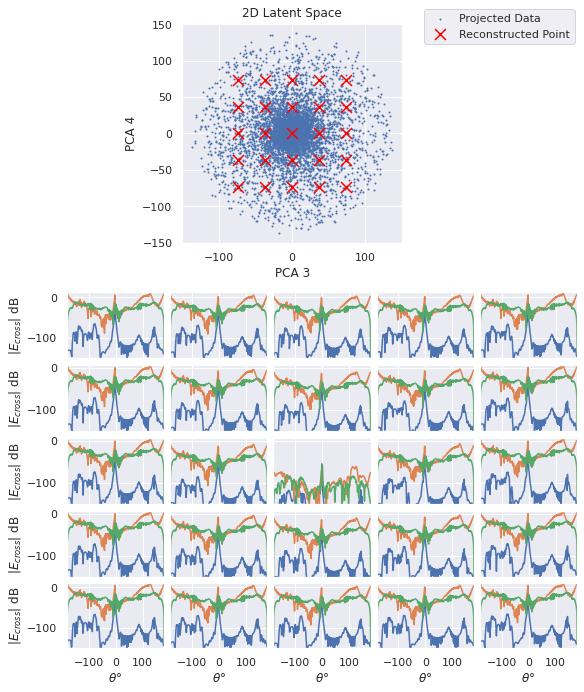

In [13]:
from ssapp.visualization.PCA_Visualisation import plotInverseTransformStandardPCA
plotInverseTransformStandardPCA(dataset_train,component='co',pca_components = [1,2],phi_cut = [0,1,2], num_std_dev=2,num_cols=5,num_rows=5)
figSaver.save('InversePCA_MLA_CO')
plotInverseTransformStandardPCA(dataset_train,component='cross',pca_components = [1,2],phi_cut = [0,1,2], num_std_dev=2,num_cols=5,num_rows=5)
figSaver.save('InversePCA_MLA_Cross')

plotInverseTransformStandardPCA(dataset_train,component='co',pca_components = [3,4],phi_cut = [0,1,2], num_std_dev=2,num_cols=5,num_rows=5)
figSaver.save('InversePCA_MLA_CO')
plotInverseTransformStandardPCA(dataset_train,component='cross',pca_components = [3,4],phi_cut = [0,1,2], num_std_dev=2,num_cols=5,num_rows=5)
figSaver.save('InversePCA_MLA_Cross')

In [5]:
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset,train_test_dataloader_split
from torch.utils.data.dataloader import DataLoader
from ssapp.data.Metrics import relRMSE
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern



dataset_train = load_serialized_dataset('MLADataset1_Train')
dataset_val = load_serialized_dataset('MLADataset1_Val')

train_dataloader = DataLoader(dataset_train,batch_size = len(dataset_train))
val_dataloader = DataLoader(dataset_val,batch_size = len(dataset_val))


train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))

kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(10, length_scale_bounds="fixed")

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))


kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1, length_scale_bounds="fixed")

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))


Pipeline(steps=[('scaler', StandardScaler()),
                ('gp',
                 GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                                          normalize_y=True))])

In [6]:

print(score(std_gp,train_params,train_fields))

print(score(std_gp,val_params,val_fields))

6.585241977027628e-11
0.6108339109419822


In [7]:
print(params.shape)
print(fields.shape)

torch.Size([7000, 10])
torch.Size([7000, 361, 3, 4])
